# Data Analysis

## Cargando dataset y preparación

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# Configuración Jupyter
pd.set_option('display.max_columns', None)
sns.set_style("darkgrid")

# Cargamos el dataframe final de extracción, donde están todas las canciones, con duplicados (los hemos dejado
# por si utilizamos en algún momento la columna position)
data_ana = pd.read_csv("data_global.csv", sep = ',', parse_dates=['release_year'])
print('Tamaño inicial: ',data_ana.shape)

# Quitamos las columnas que no usaremos casi seguro y sobran
data_ana= data_ana.drop(columns=['Unnamed: 0', 'Position'])
print('Tamaño con columnas que nos interesan: ', data_ana.shape)

# Quitamos los duplicados por canciones, no nos sirven de momento para el análisis principal.
data_ana = data_ana.drop_duplicates(subset='spotify_id').copy()
print('Tamaño sin duplicados de canciones: ', data_ana.shape)

# Para analizar teniendo en cuenta los streams totales yq ue esté ponderado, calculamos los pesos de cada canción respecto a los streams totales
# Importante hacerlo una vez quitados los duplicados
# Versión optimizada corta y sin warnings

data_ana_2020 = data_ana.loc[data_ana['year'] == 2020]
data_ana_2019 = data_ana.loc[data_ana['year'] == 2019]
data_ana_2018 = data_ana.loc[data_ana['year'] == 2018]
data_ana_2017 = data_ana.loc[data_ana['year'] == 2017]

data_ana.loc[data_ana.year == 2020, 'streamstotal_weights'] = data_ana_2020['Streamstotal']/data_ana_2020['Streamstotal'].sum()
data_ana.loc[data_ana.year == 2019, 'streamstotal_weights'] = data_ana_2019['Streamstotal']/data_ana_2019['Streamstotal'].sum()
data_ana.loc[data_ana.year == 2018, 'streamstotal_weights'] = data_ana_2018['Streamstotal']/data_ana_2018['Streamstotal'].sum()
data_ana.loc[data_ana.year == 2017, 'streamstotal_weights'] = data_ana_2017['Streamstotal']/data_ana_2017['Streamstotal'].sum()

# COMPROBACIONES: Deberían sumar 1 los pesos de cada año
print('Peso 2020: ', data_ana.loc[data_ana['year'] == 2020, 'streamstotal_weights'].sum())
print('Peso 2019: ', data_ana.loc[data_ana['year'] == 2019, 'streamstotal_weights'].sum())
print('Peso 2018: ', data_ana.loc[data_ana['year'] == 2018, 'streamstotal_weights'].sum())
print('Peso 2017: ', data_ana.loc[data_ana['year'] == 2017, 'streamstotal_weights'].sum())

#Ver cómo sale
data_ana[data_ana['Track Name'] == 'Punto G']

#Revisamos los tipos de datos:
data_ana.info()

Tamaño inicial:  (48066, 38)
Tamaño con columnas que nos interesan:  (48066, 36)
Tamaño sin duplicados de canciones:  (1581, 36)
Peso 2020:  1.0
Peso 2019:  0.9999999999999999
Peso 2018:  1.0
Peso 2017:  1.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1581 entries, 0 to 48064
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Track Name            1581 non-null   object        
 1   Artist                1581 non-null   object        
 2   Streams               1581 non-null   int64         
 3   date                  1581 non-null   object        
 4   spotify_id            1581 non-null   object        
 5   year                  1581 non-null   int64         
 6   Streamstotal          1581 non-null   int64         
 7   album                 1581 non-null   object        
 8   release_date          1581 non-null   object        
 9   length                1581 non-null   flo

/Users/victormac/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (30,31,32,33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Genres analysis

Para identificar cada canción con un género se plantearon incialmente dos formas:
1. Crear un modelo de clasificación, que por sus features, clasificara todas las canciones en grupos que luego identifciariamos. En internet encontré mucha documentación y trabajos que hacen esto, y en la mayoría no subían de un score de 60-70, por lo que era difícil una buena clasificación por las features. Aún así, hice algunas pruebas y no conseguí buenos resultados, como esperaba. 
2. De la API de Spotify sacar directamente los géneros del artistas y con un análisis previo de los datos, crear grupos generalizables teniendo en cuenta los nombres de los géneros. Por ejemplo, si una canción estaba clasificada como "trap espanol", se le agrupaba en el género hiphop, por considerar yo mismo que entra dentro de este grupo por su parecido. Evidemente esto supuso también escuchar muchos géneros que ni conocía y el nombre no daba pistas y clasificarlos.

Elegí el segundo camino.


De los artistas hemos extraido los géneros en los que están clasificados en Spotify, que no nos dice solo uno, sino hasta 10 diferentes, lo que nos dificulta dsitinguir poeque algunos artistas tienen hasta 5 géneros asignados que pueden coincidir o no con otros artistas. Esto puede desvirtuar el análisis y dificultar la agrupación de estilos, porque si, por ejemplo, una canción puede tener como genre1 un género muy específico (ej. colombian pop) y está como el primero en la lista del artista, en vez de un género más general (ej. pop).

En la extracción hemos metido cada género del artista en una columna para faciilitar los análisis (genre1, genre2, genre3...). Por si acaso, hemos dejado una columna con la lista completa.

In [2]:
# Echamos un primer vistazo a las columnas
data_ana[data_ana['genre2'] =='latin'].head(3)

,Track Name,Artist,Streams,date,spotify_id,year,Streamstotal,album,release_date,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,time_signature,release_year,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10,genres_together,artist_id,artist_followers,artist_popularity,streamstotal_weights
10358,Coronao Now (Remix),El Alfa,82555,2020-03-13,047WmwIeerHyIUstFAEz5A,2020,3143292,Coronao Now (Remix),2020-02-12,0.451159,0.72,0.255,0.883,0.853,0.000723,0.412,0.862410,0.209612,0.695,0.371194,4,2020-01-01,dembow,latin,rap dominicano,reggaeton,tropical,NaN,NaN,NaN,NaN,NaN,"dembow,latin,rap dominicano,reggaeton,tropical",2oQX8QiMXOyuqbcZEFsZfm,1102798,0.838384,0.002806
10407,4K,El Alfa,56099,2020-03-13,4xI3U4sDj1TPmO9Iz5TkYp,2020,4475589,4K,2020-03-12,0.326357,0.80,0.357,0.925,0.900,0.005950,0.124,0.875936,0.174870,0.804,0.384744,4,2020-01-01,dembow,latin,rap dominicano,reggaeton,tropical,NaN,NaN,NaN,NaN,NaN,"dembow,latin,rap dominicano,reggaeton,tropical",2oQX8QiMXOyuqbcZEFsZfm,1102798,0.838384,0.003995
10468,Coronao Now,El Alfa,46034,2020-03-13,7FbKipScVxkjQxQXwTd0gL,2020,446298,Coronao Now,2019-11-07,0.368363,0.70,0.146,0.941,0.729,0.004510,0.180,0.770913,0.322525,0.718,0.371348,4,2019-01-01,dembow,latin,rap dominicano,reggaeton,tropical,NaN,NaN,NaN,NaN,NaN,"dembow,latin,rap dominicano,reggaeton,tropical",2oQX8QiMXOyuqbcZEFsZfm,1102798,0.838384,0.000398


In [3]:
# Vemos los artistas que más veces salen 
data_ana.Artist.value_counts()

Bad Bunny         44
J Balvin          31
Ozuna             28
C. Tangana        25
Ed Sheeran        22
                  ..
JP Saxe            1
Beatriz Luengo     1
Bruno Martini      1
Amaia Montero      1
Zetazen            1
Name: Artist, Length: 452, dtype: int64

In [4]:
#Contamos el número de canciones para cada género analizando la columna genre1 y siguientes
number_genres = data_ana.genre1.value_counts()
number_genres.head(60)

latin                        366
dance pop                    199
colombian pop                 83
latin pop                     68
pop                           58
cantautor                     54
flamenco urbano               45
spanish pop                   44
trap espanol                  42
latin arena pop               33
big room                      31
r&b en espanol                28
canadian contemporary r&b     22
argentine hip hop             21
electropop                    20
latin viral pop               20
canadian hip hop              19
reggaeton                     17
dominican pop                 16
modern rock                   15
dfw rap                       13
eurovision                    13
boy band                      12
conscious hip hop             12
rap espanol                   12
champeta                      11
garage rock                   11
panamanian pop                11
canadian pop                  11
trap latino                   10
cubaton   

Tras analizar los valores principales, vemos que el género "latin" es muy ambiguo y no nos ayuda a grupa, por lo que decido que para depurar el género definitivo, a los que en el genre1 sea "latin", se les asignará el valor en genre2, que es más específico y los que el genre1 no sea latin se les asignara ese genre1. También si en el genre2 es "latin pop", que se seleccione el genre3

In [5]:
data_ana_nolatinfirst = data_ana[data_ana['genre1'] != 'latin']
data_ana_latinfirst = data_ana[data_ana['genre1'] == 'latin']

data_ana.loc[data_ana.genre1 == 'latin', 'genre_final'] = data_ana_latinfirst['genre2']
data_ana.loc[data_ana.genre2 == 'latin pop', 'genre_final'] = data_ana_latinfirst['genre3']
data_ana.loc[data_ana.genre1 != 'latin', 'genre_final'] = data_ana_nolatinfirst['genre1']

data_ana.shape

(1581, 38)

In [6]:
# Vemos cómo queda ahora distribuidos los géneros y se ve algo más claro, quitando el "latin"
number_genres_new = data_ana.genre_final.value_counts()
number_genres_new.head(60)

dance pop                    199
reggaeton                    152
latin hip hop                 86
colombian pop                 83
latin arena pop               75
latin pop                     68
pop                           58
cantautor                     54
spanish pop                   49
puerto rican pop              47
flamenco urbano               45
trap espanol                  42
r&b en espanol                41
big room                      31
canadian contemporary r&b     22
latin viral pop               22
argentine hip hop             21
electropop                    20
canadian hip hop              19
reggaeton flow                18
dominican pop                 16
modern rock                   15
dfw rap                       13
eurovision                    13
conscious hip hop             12
rap espanol                   12
boy band                      12
panamanian pop                11
canadian pop                  11
garage rock                   11
champeta  

Tras un análisis por géneros, vemos que es complicado agrupar por elevado número de géneros y porque el primer género del listado de cada artista no distingue bien.

Entonces la idea seria hacer nosotros la agrupación seleccionando los géneros que puedan agrupar mejor y además evitando errores y teniendo en cuenta no sólo el primero género sino los siguientes.

El método para sacar el género final ha sido recoger el genre1 como principal pero obviando otros como latin. Es decir, si hacemos una revisión de genre1 y se encuentra latin, pasamos a seleccionar el género de genre2 y así sucesivamente.

Se ha decidido elegir los siguientes géneros: POP, DANCEPOP, ROCK, RAP, CANTAUTOR Y REGAETTON. Evidentemente este es un agrupamiento subjetivo y teniendo en cuanto los géneros que aparece más en genre1 y que podemos distinguir fácilmente entre ellos. Por ejemplo, "reggaeton" podría entrar tambien en "dance", pero se ha decidido separarlo por el volumen menciones a este géneros y se ha agrupado con similares.

In [7]:
# Grupos de géneros:
list_genres_pop = 'pop, k-pop, boy band, eurovision, carnaval'
list_genres_dance = 'dance, tropical, edm, electropop, big room'
list_genres_rock = 'rock, indie'
list_genres_reggaeton = 'dembow, reggaeton, champeta, cubaton'
list_genres_rap = "rap, hip hop, funk, trap, r&b"
cantautor = 'cantautor, flamenco'

In [8]:
print(data_ana.shape)
data_ana.head(2)

(1581, 38)


,Track Name,Artist,Streams,date,spotify_id,year,Streamstotal,album,release_date,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,time_signature,release_year,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10,genres_together,artist_id,artist_followers,artist_popularity,streamstotal_weights,genre_final
0,Tusa,KAROL G,432730,2020-03-13,7k4t7uLgtOxPwTpFmtJNTY,2020,19082982,Tusa,2019-11-07,0.324972,0.91,0.295,0.803,0.715,0.000134,0.0574,0.911425,0.397800,0.574,0.258160,4,2019-01-01,latin,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"latin,reggaeton,reggaeton colombiano",790FomKkXshlbRYZFtlgla,11463195,0.878788,0.017033,reggaeton
61,Follow,KAROL G,152745,2020-04-02,2w1rq80FIrbxeJy9WYURxw,2020,6900319,Follow,2020-04-01,0.330442,0.78,0.667,0.735,0.787,0.000006,0.0721,0.875476,0.198031,0.455,0.711901,4,2020-01-01,latin,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"latin,reggaeton,reggaeton colombiano",790FomKkXshlbRYZFtlgla,11463195,0.878788,0.006159,reggaeton


In [9]:
data_ana['genre_depurated'] = pd.np.where(data_ana.genre_final.str.contains("dance"), 'dance',
                              pd.np.where(data_ana.genre_final.str.contains("tropical"), 'dance',            
                              pd.np.where(data_ana.genre_final.str.contains("edm"), 'dance',
                              pd.np.where(data_ana.genre_final.str.contains("electropop"), 'dance',
                              pd.np.where(data_ana.genre_final.str.contains("big room"), 'dance',
                                          
                              pd.np.where(data_ana.genre_final.str.contains("pop"), 'pop',
                              pd.np.where(data_ana.genre_final.str.contains("k-pop"), 'pop',
                              pd.np.where(data_ana.genre_final.str.contains("carnaval"), 'pop',                      
                              pd.np.where(data_ana.genre_final.str.contains("eurovision"), 'pop',
                              pd.np.where(data_ana.genre_final.str.contains("boy band"), 'pop',
                        
                              pd.np.where(data_ana.genre_final.str.contains("rock"), 'rock',            
                              pd.np.where(data_ana.genre_final.str.contains("indie"), 'rock',
                                          
                              pd.np.where(data_ana.genre_final.str.contains("bachata"), 'reggaeton',                               
                              pd.np.where(data_ana.genre_final.str.contains("dembow"), 'reggaeton',            
                              pd.np.where(data_ana.genre_final.str.contains("reggaeton"), 'reggaeton',            
                              pd.np.where(data_ana.genre_final.str.contains("champeta"), 'reggaeton',
                              pd.np.where(data_ana.genre_final.str.contains("cubaton"), 'reggaeton',
                                          
                              pd.np.where(data_ana.genre_final.str.contains("hip hop"), 'hip hop',            
                              pd.np.where(data_ana.genre_final.str.contains("rap"), 'hip hop',            
                              pd.np.where(data_ana.genre_final.str.contains("funk"), 'hip hop',            
                              pd.np.where(data_ana.genre_final.str.contains("trap"), 'hip hop',            
                              pd.np.where(data_ana.genre_final.str.contains("r&b"), 'hip hop',
                                          
                              pd.np.where(data_ana.genre_final.str.contains("cantautor"), 'cantautor',            
                              pd.np.where(data_ana.genre_final.str.contains("flamenco"), 'cantautor',            
                                    
                                          "other"))))))))))))))))))))))))
data_ana[data_ana['genre_final'] == 'dembow']




<ipython-input-9-f44ac0a4e679>:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  data_ana['genre_depurated'] = pd.np.where(data_ana.genre_final.str.contains("dance"), 'dance',
<ipython-input-9-f44ac0a4e679>:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  pd.np.where(data_ana.genre_final.str.contains("tropical"), 'dance',
<ipython-input-9-f44ac0a4e679>:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  pd.np.where(data_ana.genre_final.str.contains("edm"), 'dance',
<ipython-input-9-f44ac0a4e679>:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  pd.np.where(data_ana.genre_final.str.contains("electropop"), 'dance',
<ipython-input-9-f44ac0a4e67

,Track Name,Artist,Streams,date,spotify_id,year,Streamstotal,album,release_date,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,time_signature,release_year,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10,genres_together,artist_id,artist_followers,artist_popularity,streamstotal_weights,genre_final,genre_depurated
10358,Coronao Now (Remix),El Alfa,82555,2020-03-13,047WmwIeerHyIUstFAEz5A,2020,3143292,Coronao Now (Remix),2020-02-12,0.451159,0.72,0.255,0.883,0.853,0.000723,0.4120,0.862410,0.209612,0.695,0.371194,4,2020-01-01,dembow,latin,rap dominicano,reggaeton,tropical,NaN,NaN,NaN,NaN,NaN,"dembow,latin,rap dominicano,reggaeton,tropical",2oQX8QiMXOyuqbcZEFsZfm,1102798,0.838384,0.002806,dembow,reggaeton
10407,4K,El Alfa,56099,2020-03-13,4xI3U4sDj1TPmO9Iz5TkYp,2020,4475589,4K,2020-03-12,0.326357,0.80,0.357,0.925,0.900,0.005950,0.1240,0.875936,0.174870,0.804,0.384744,4,2020-01-01,dembow,latin,rap dominicano,reggaeton,tropical,NaN,NaN,NaN,NaN,NaN,"dembow,latin,rap dominicano,reggaeton,tropical",2oQX8QiMXOyuqbcZEFsZfm,1102798,0.838384,0.003995,dembow,reggaeton
10468,Coronao Now,El Alfa,46034,2020-03-13,7FbKipScVxkjQxQXwTd0gL,2020,446298,Coronao Now,2019-11-07,0.368363,0.70,0.146,0.941,0.729,0.004510,0.1800,0.770913,0.322525,0.718,0.371348,4,2019-01-01,dembow,latin,rap dominicano,reggaeton,tropical,NaN,NaN,NaN,NaN,NaN,"dembow,latin,rap dominicano,reggaeton,tropical",2oQX8QiMXOyuqbcZEFsZfm,1102798,0.838384,0.000398,dembow,reggaeton
13872,Rueda,Chimbala,68669,2020-03-13,4NDHYPVJ5zLnR8yYZsMDsu,2020,3886123,Rueda,2019-07-19,0.349507,0.69,0.165,0.888,0.916,0.000004,0.0519,0.947012,0.099884,0.960,0.451617,4,2019-01-01,dembow,dominican pop,flamenco urbano,latin,rap dominicano,NaN,NaN,NaN,NaN,NaN,"dembow,dominican pop,flamenco urbano,latin,rap...",4VVEpEhC8NcR7AqNEds42U,208322,0.696970,0.003469,dembow,reggaeton
13933,Rueda - Remix,Chimbala,72331,2020-03-20,3EWxpqOSP0KWgUmRiklqGy,2020,5375648,Rueda (Remix),2020-03-19,0.354069,0.71,0.256,0.864,0.925,0.000009,0.0648,0.957420,0.072669,0.961,0.451744,4,2020-01-01,dembow,dominican pop,flamenco urbano,latin,rap dominicano,NaN,NaN,NaN,NaN,NaN,"dembow,dominican pop,flamenco urbano,latin,rap...",4VVEpEhC8NcR7AqNEds42U,208322,0.696970,0.004798,dembow,reggaeton
16845,La Rubia - Remix 2,La Nueva Escuela,59557,2020-03-13,7KKTnv81z6DmfPIGsZWjOW,2020,3262919,La Rubia,2019-04-19,0.350359,0.68,0.319,0.758,0.717,0.000006,0.3780,0.881418,0.156051,0.753,0.316969,4,2019-01-01,dembow,dominican pop,flamenco urbano,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"dembow,dominican pop,flamenco urbano",7mcJN2bWqCv7jvykgHp4KN,64760,0.575758,0.002912,dembow,reggaeton
27049,Ellos,Ceky Viciny,34777,2020-03-17,7bDboJVS7UlQBZj8lsvz2g,2020,1262764,Ellos,2019-07-05,0.258610,0.45,0.124,0.754,0.939,0.002810,0.2930,0.954990,0.022438,0.853,0.397939,4,2019-01-01,dembow,dominican pop,flamenco urbano,rap dominicano,NaN,NaN,NaN,NaN,NaN,NaN,"dembow,dominican pop,flamenco urbano,rap domin...",5UopXhshFFqRIMfeZrBclq,62735,0.595960,0.001127,dembow,reggaeton
27085,Ellos,Ceky Viciny,31018,2019-04-18,1tDUwlIyFFcmfMypYoQ4Ns,2019,1895505,Ellos,2019-03-11,0.258610,0.00,0.124,0.754,0.939,0.002810,0.2930,0.954990,0.022438,0.853,0.397939,4,2019-01-01,dembow,dominican pop,flamenco urbano,rap dominicano,NaN,NaN,NaN,NaN,NaN,NaN,"dembow,dominican pop,flamenco urbano,rap domin...",5UopXhshFFqRIMfeZrBclq,62735,0.595960,0.002033,dembow,reggaeton
34896,Mujeres,Mozart La Para,46137,2019-03-13,6xLvYhLOW2oETJoZv8ChU8,2019,1882677,Mujeres,2018-06-08,0.290882,0.60,0.204,0.835,0.767,0.000079,0.2610,0.832009,0.065721,0.710,0.250723,4,2018-01-01,dembow,dominican pop,rap dominicano,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"dembow,dominican pop,rap dominicano",0odliLZMTk45CEVzF3Zocl,256200,0.696970,0.002019,dembow,reggaeton


In [10]:
prueba_data = data_ana[data_ana['year'] == 2017]
prueba_data['streamstotal_weights'].sum()

1.0

In [11]:
number_genres2 = data_ana.genre_depurated.value_counts()
number_genres2.head(60)

pop          526
hip hop      351
dance        286
reggaeton    211
cantautor     99
other         68
rock          40
Name: genre_depurated, dtype: int64

In [12]:
#Total reproducciones 
data_group = data_ana.groupby(['genre_depurated', 'year']).agg(['sum', 'count'])
data_group['streamstotal_weights']
#Falta hacerlo por ponderación con reproducciones

sum  count
genre_depurated year                 
cantautor       2017  0.014904     18
                2018  0.021055     18
                2019  0.021709     23
                2020  0.061604     40
dance           2017  0.312284     95
                2018  0.195068     87
                2019  0.148904     63
                2020  0.069684     41
hip hop         2017  0.162368     70
                2018  0.229530    102
                2019  0.237541     68
                2020  0.224726    111
other           2017  0.052695     24
                2018  0.020286     15
                2019  0.037632     16
                2020  0.014187     13
pop             2017  0.312587    125
                2018  0.385002    133
                2019  0.352290    141
                2020  0.306452    127
reggaeton       2017  0.129028     36
                2018  0.143896     32
                2019  0.196564     54
                2020  0.319103     89
rock            2017  0.016134     16
                2018  0.005163     14
                2019  0.005359      7
                2020  0.004244      3

In [13]:
data_group2 = data_group['Streamstotal']
data_group2.reset_index(inplace=True)
data_group2

,genre_depurated,year,sum,count
0,cantautor,2017,6308920,18
1,cantautor,2018,14818224,18
2,cantautor,2019,20243671,23
3,cantautor,2020,69019989,40
4,dance,2017,132189673,95
5,dance,2018,137286328,87
6,dance,2019,138854616,63
7,dance,2020,78071718,41
8,hip hop,2017,68730290,70
9,hip hop,2018,161540315,102


/Users/victormac/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


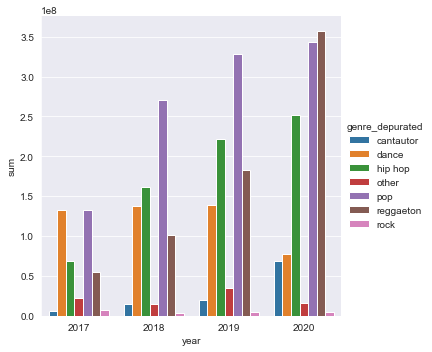

In [14]:
#Cálculo de los streams totales de cada género depurado

data_group = data_ana.groupby(['genre_depurated', 'year']).agg(['sum', 'count'])
data_group2 = data_group['Streamstotal']
data_group2.reset_index(inplace=True)
sns.factorplot(x='year', y='sum', hue='genre_depurated', data=data_group2, kind='bar')


In [15]:
# Calculo de porcentajes para comparar por año, PONDERADO
# Habría que calcular el porcentaje respecto al total del año y comparar esos porcentaje entre años


#Para ello hemos creado una función para extraerlo más fácil donde se mete el año y el género:
def extract_percentage(year, genre):
    datos_ano = data_group2[data_group2['year'] == year]
    percentage = 100 * datos_ano[datos_ano['genre_depurated'] == genre].sum()[2]/ data_group2[data_group2['year'] == year].sum()[2]
    return [year, genre, percentage]

#Y otra función para crear el dataframe resultante por año
def create_df_year(year):
    list_genres = ['pop', 'dance', 'rock','reggaeton','hip hop','cantautor']
    data_1 = extract_percentage(year, list_genres[0])
    data_2 = extract_percentage(year, list_genres[1])
    data_3 = extract_percentage(year, list_genres[2])
    data_4 = extract_percentage(year, list_genres[3])
    data_5 = extract_percentage(year, list_genres[4])
    data_6 = extract_percentage(year, list_genres[5])   
    df_new = pd.DataFrame([data_1, data_2,data_3,data_4,data_5,data_6,], columns = ['year', 'genre', 'percentage'])
    return df_new

# Guardamos dataframes
data_genre_2017 = create_df_year(2017)
data_genre_2018 = create_df_year(2018)
data_genre_2019 = create_df_year(2019)
data_genre_2020 = create_df_year(2020)

# Juntar dataframes
data_genre_years = pd.concat([data_genre_2017, data_genre_2018, data_genre_2019, data_genre_2020])


#Hacer comparativa de géneros por años
data_genre_pop = data_years[data_years['genre'] == 'pop']
sns.catplot(x="year", y="percentage", data=data_genre_pop,
                height=6, kind="bar", palette="muted")

data_genre_regga = data_years[data_years['genre'] == 'reggaeton']
sns.catplot(x="year", y="percentage", data=data_genre_regga,
                height=6, kind="bar", palette="muted")



NameError: name 'data_years' is not defined

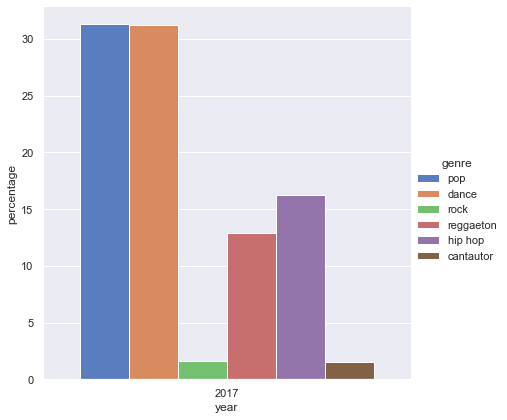

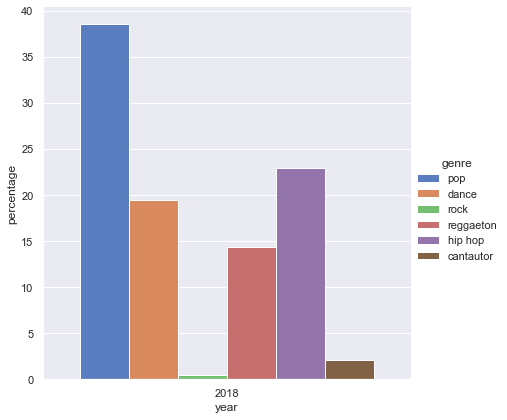

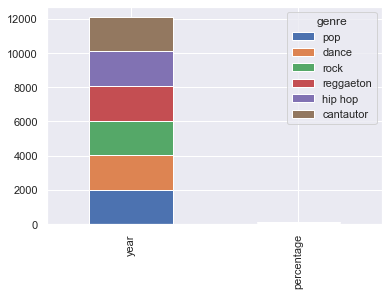

In [60]:
#graficos pruebas

a = sns.catplot(x="year", y="percentage", hue="genre", data=data_genre_2017,
                height=6, kind="bar", palette="muted")
b = sns.catplot(x="year", y="percentage", hue="genre", data=data_genre_2018,
                height=6, kind="bar", palette="muted")

sns.set()
data_genre_2018.set_index('genre').T.plot(kind='bar', stacked=True)


In [41]:
data_group = data_ana.groupby(['genre_depurated', 'year']).agg(['sum', 'count'])
data_group['Streamstotal']

sum  count
genre_depurated                            year                  
cantautor, flamenco                        2017    6308920     18
                                           2018   14818224     18
                                           2019   20243671     23
                                           2020   69019989     40
dance, tropical, edm, electropop, big room 2017  132189673     95
                                           2018  137286328     87
                                           2019  138854616     63
                                           2020   78071718     41
dembow, reggaeton, champeta, cubaton       2017   54617542     36
                                           2018  101271842     32
                                           2019  183297902     54
                                           2020  357515126     89
other                                      2017   22305926     24
                                           2018   14277073     15
                                           2019   35092157     16
                                           2020   15894422     13
pop, k-pop, boy band, eurovision, carnaval 2017  132317751    125
                                           2018  270959552    133
                                           2019  328513264    141
                                           2020  343340538    127
rap, hip hop, funk, trap, r&b              2017   68730290     70
                                           2018  161540315    102
                                           2019  221508584     68
                                           2020  251776721    111
rock, indie                                2017    6829464     16
                                           2018    3633433     14
                                           2019    4997683      7
                                           2020    4755101      3

In [17]:
data_group3 = data_ana.groupby(['genre1', 'year']).agg(['sum', 'count'])
data_group3['Streamstotal'].sort_values(by='count', ascending=False)

sum  count
genre1             year                  
latin              2020  464763574    121
                   2019  362823182     99
                   2018  287218756     83
                   2017  111362949     77
dance pop          2017  103763118     75
...                            ...    ...
dancehall          2017    5726377      1
czech pop          2018     108262      1
cumbia             2018    1492895      1
cubaton            2020     874083      1
venezuelan hip hop 2020     764827      1

[234 rows x 2 columns]

In [ ]:
# volver a intentar probando!!!
data_group4 = data_ana.groupby(['genre1', 'year']).agg(['sum', 'count'])
data_group3['Streamstotal'].sort_values(by='count', ascending=False)